# Bootstrapping

Bootstrapping in time series forecasting is a non-parametric method for generating prediction intervals that does not assume a normal distribution for the forecast errors. Instead, it relies on re-sampling historical residuals to simulate multiple possible future scenarios.
The process involves these key steps:
- **Model Fitting:** Fit a deterministic forecasting model (e.g., Exponential Smoothing, ARIMA) to the training data to obtain point forecasts.
- **Residuals Calculation:** Compute the residuals (errors) by subtracting the model's fitted values from the actual training data.
- **Residual Sampling:** Repeatedly draw samples with replacement from the historical residuals.
- **Simulation:** For each sampled residual, add it to the point forecast to create a simulated future path.
- **Distribution Calculation:** Calculate the prediction intervals (e.g., 95% interval) from the distribution of the simulated future paths.

# Implementing bootstrap with Darts

This is an implementation of the bootstrap method using Darts the Air Passengers dataset. This is a more robust approach than the parametric method, especially when the residuals are not normally distributed.

# Setup and data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.models import ExponentialSmoothing
import numpy as np

# Define the URL for the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Use pandas to read the CSV directly from the URL
df = pd.read_csv(url, delimiter=',', parse_dates=['Month'])
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df.set_index('Month', inplace=True)

# Convert the pandas DataFrame to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, value_cols='Passengers')

# Split the dataset into training and validation sets
train, val = series[:-36], series[-36:]

c:\Users\vnour\miniconda3\envs\py310\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\vnour\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Build and train the model

First, we need to fit the base model and obtain the historical residuals, which will be used for bootstrapping.

In [2]:
# Specify the seasonal period explicitly
model = ExponentialSmoothing(seasonal_periods=12)
model.fit(train)

# Assuming a seasonal period of 12 for the Air Passengers dataset
warmup_period = model.seasonal_periods * 2

# Use historical_forecasts with retrain=True to get fitted values
fitted_values = model.historical_forecasts(
    series,
    start=warmup_period,
    forecast_horizon=1,
    retrain=True,
    last_points_only=True
)

# Calculate residuals using slice_intersect() for robust alignment
residuals_ts = series.slice_intersect(fitted_values) - fitted_values.slice_intersect(series)

# Get the residuals as a numpy array, filtering out any NaNs
residuals = residuals_ts.values().flatten()
residuals = residuals[~np.isnan(residuals)]

print(f"Shape of residuals: {residuals.shape}")

Shape of residuals: (120,)


# Generate bootstrap forecast
Next, we generate multiple simulated forecasts by re-sampling the residuals.

In [22]:
# Horizon for the forecast
forecast_horizon = len(val)

# Number of bootstrap samples
num_samples = 1000

# Container for all bootstrap forecasts
bootstrap_forecasts = []

# Use a dedicated random number generator for consistency
rng = np.random.RandomState()

# Generate bootstrap forecasts by re-sampling residuals
for _ in range(num_samples):
    # Predict the future point forecast
    point_forecast = model.predict(forecast_horizon, num_samples=1)
    
    # Resample residuals with replacement
    resampled_residuals_np = rng.choice(residuals, size=forecast_horizon, replace=True)
    
    # Convert the NumPy array into a Darts TimeSeries
    # It's important to give it the same time index as the forecast
    resampled_residuals_ts = TimeSeries.from_times_and_values(
        times=point_forecast.time_index,
        values=resampled_residuals_np
    )
    
    # Add the resampled residuals (now a TimeSeries) to the point forecast
    bootstrapped_forecast = point_forecast + resampled_residuals_ts
    
    # Store the bootstrapped forecast
    bootstrap_forecasts.append(bootstrapped_forecast)

# Concatenate all bootstrapped forecasts into a single TimeSeries object
bootstrap_series = concatenate(bootstrap_forecasts, axis="sample")


# Plot a few sample paths

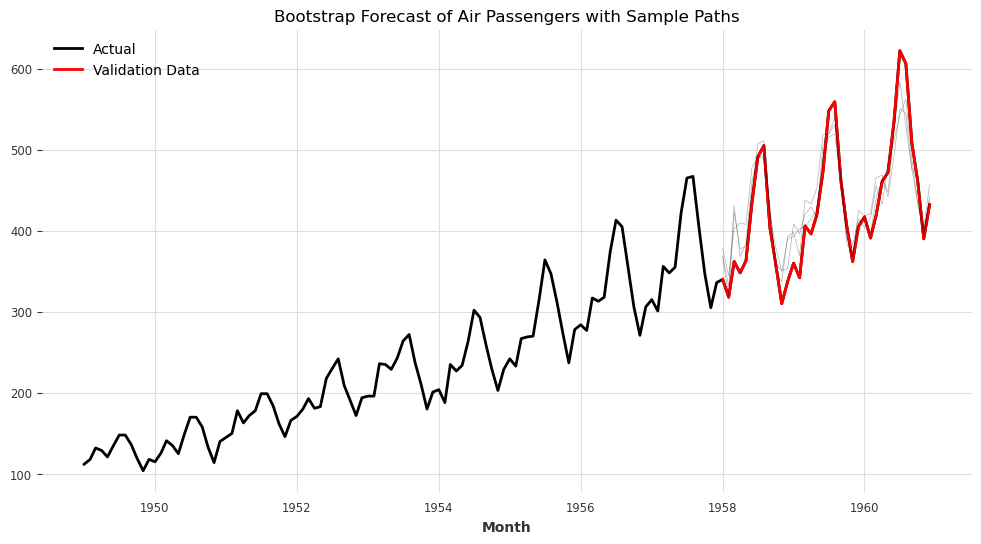

In [24]:
# Assuming series, val, and bootstrap_series are already defined

plt.figure(figsize=(12, 6))

# Plot the actual and validation data
series.plot(label='Actual')
val.plot(label='Validation Data', color='red')

# --- Plot a few sample paths ---
# Select a small, random subset of samples to plot
num_samples_to_plot = 3
sample_indices = np.random.choice(bootstrap_series.n_samples, size=num_samples_to_plot, replace=False)

# Get all values as a NumPy array
bootstrap_series_val = bootstrap_series.all_values()

for i in sample_indices:
    # Select a specific sample by its index (e.g., the second sample, which has index 1)
    sample_path = bootstrap_series_val[:, :, i]
    sample_path_ts = TimeSeries.from_times_and_values(
        times=bootstrap_series.time_index,
        values=sample_path.flatten()
    )

    sample_path_ts.plot(color='black', lw=0.5, alpha=0.3, label=None)

plt.title('Bootstrap Forecast of Air Passengers with Sample Paths')
plt.legend()
plt.show()

# Analyze and visualize the results

Finally, we plot the bootstrap forecast, including the median and the desired prediction intervals.

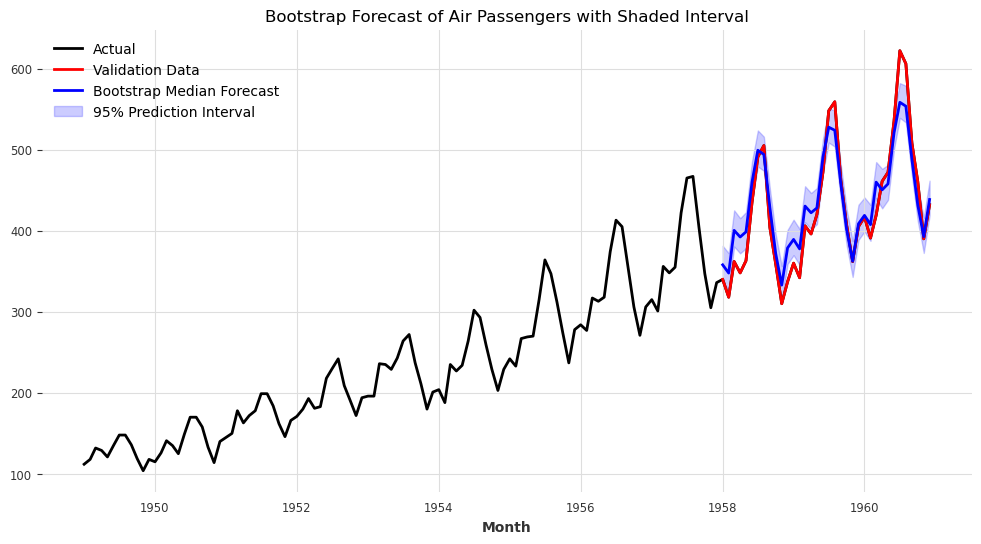

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming bootstrap_series, series, and val are defined

# Get the quantiles for plotting the shaded region
low_quantile = bootstrap_series.quantile(0.05).to_series()
high_quantile = bootstrap_series.quantile(0.95).to_series()

plt.figure(figsize=(12, 6))

# Plot the actual and validation data
series.plot(label='Actual')
val.plot(label='Validation Data', color='red')

# Plot the median forecast
bootstrap_series.median().plot(label='Bootstrap Median Forecast', color='blue', lw=2)

# Plot the 95% prediction interval as a shaded region
plt.fill_between(
    low_quantile.index,
    low_quantile.values,
    high_quantile.values,
    color='blue',
    alpha=0.2,
    label='95% Prediction Interval'
)

plt.title('Bootstrap Forecast of Air Passengers with Shaded Interval')
plt.legend()
plt.show()